In [42]:
### This is the Google Colab notebook the neural network was developed in

# Install nltk
!pip install --user -U nltk

Requirement already up-to-date: nltk in /root/.local/lib/python3.6/site-packages (3.5)


In [43]:
# Import all libraries
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
# Load dataset
data = pd.read_csv('/content/UpdatedResumeDataSet.csv', engine='python')
#data = pd.read_csv('/content/drive/My Drive/CodeDay/UpdatedResumeDataSet.csv') # Comment this line and uncomment the above line if this does not work for you
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [45]:
# Print unique categories of resumes
print(data['Category'].value_counts())

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Blockchain                   40
Mechanical Engineer          40
Data Science                 40
ETL Developer                40
Operations Manager           40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
DotNet Developer             28
Business Analyst             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


In [46]:
# Drop rows where category is "Testing" and store new size of dataset
data = data[data.Category != 'Testing']
data_size = len(data)

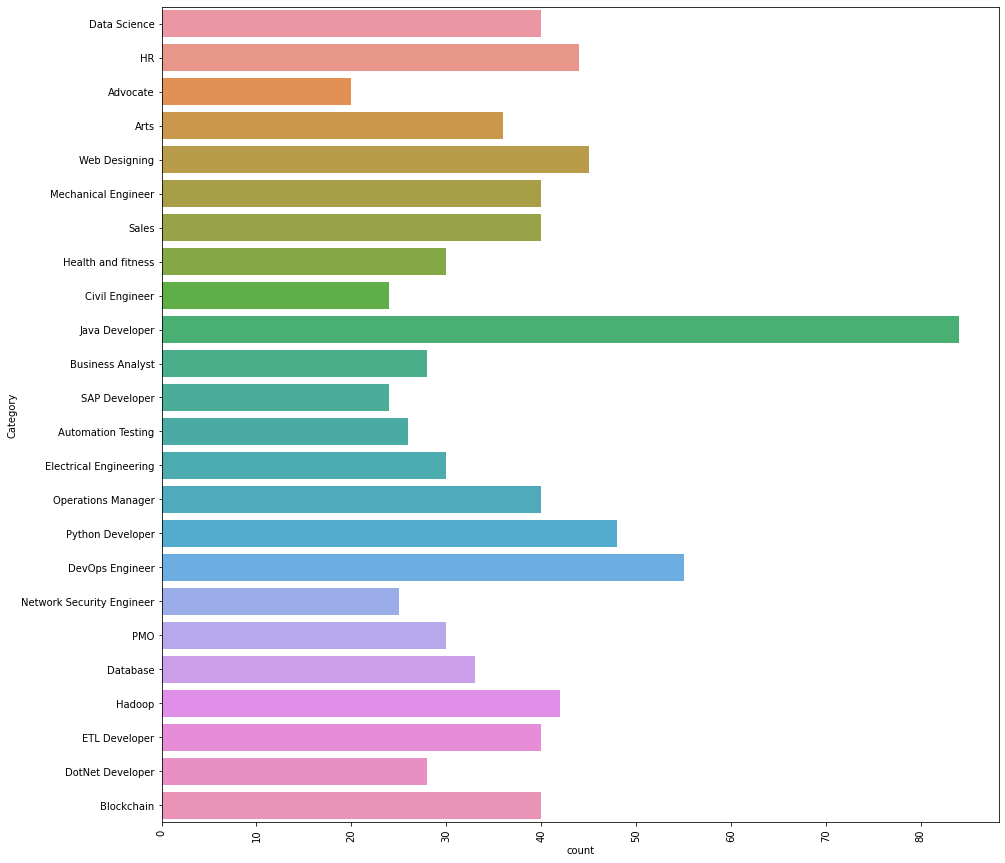

In [47]:
# Bar graph visualization
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=data)

In [48]:
# Get set of stopwords
stopwords_set = set(stopwords.words('english')+['``',"''"])

In [49]:
# Function to clean resume text
def clean_text(resume_text):
    resume_text = re.sub('http\S+\s*', ' ', resume_text)  # remove URLs
    resume_text = re.sub('RT|cc', ' ', resume_text)  # remove RT and cc
    resume_text = re.sub('#\S+', '', resume_text)  # remove hashtags
    resume_text = re.sub('@\S+', '  ', resume_text)  # remove mentions
    resume_text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resume_text)  # remove punctuations
    resume_text = re.sub(r'[^\x00-\x7f]',r' ', resume_text) 
    resume_text = re.sub('\s+', ' ', resume_text)  # remove extra whitespace
    resume_text = resume_text.lower()  # convert to lowercase
    resume_text_tokens = word_tokenize(resume_text)  # tokenize
    filtered_text = [w for w in resume_text_tokens if not w in stopwords_set]  # remove stopwords
    return ' '.join(filtered_text)

In [50]:
# Print a sample original resume
print('--- Original resume ---')
print(data['Resume'][0])

--- Original resume ---
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details 

Data Science Assurance Associate 

Data Science Assurance Associate - Ernst & Young LLP
Skill Details 
JAVASCRIPT- Exprience - 24 months
jQuery- Exprience - 24 months
Python- Exprience - 24 monthsCompany Details 
company - Ernst & Young LLP
description - Fraud Investigations and 

In [51]:
# Print the same resume after text cleaning
data['cleaned_resume'] = data.Resume.apply(lambda x: clean_text(x))

print('--- Cleaned resume ---')
print(data['cleaned_resume'][0])

--- Cleaned resume ---
skills programming languages python pandas numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm na bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural nets database visualizations mysql sqlserver cassandra hbase elasticsearch d3 js dc js plotly kibana matplotlib ggplot tableau others regular expression html css angular 6 logstash kafka python flask git docker computer vision open cv understanding deep learning education details data science assurance associate data science assurance associate ernst young llp skill details javascript exprience 24 months jquery exprience 24 months python exprience 24 monthscompany details company ernst young llp description fraud investigations dispute services assurance technology assisted review tar technology assisted review assists elerating r

In [52]:
# Get features and labels from data and shuffle
features = data['cleaned_resume'].values
original_labels = data['Category'].values
labels = original_labels[:]

for i in range(data_size):
  labels[i] = str(labels[i].lower())  # convert to lowercase
  labels[i] = labels[i].replace(" ", "")  # use hyphens to convert multi-token labels into single tokens

features, labels = shuffle(features, labels)

# Print example feature and label
print(features[0])
print(labels[0])

technical skills skills java sql pl sql c c bootstrap jsp ext js operating systems windows tools toad eclipse soapbox postman databases oracle ms sql ms ess ms exceleducation details january 2017 b e computer technology gondia maharashtra manoharbhai patel institute engineering technology hsc gondia maharashtra p science college java developer java developer xoriant solutions pvt ltd skill details company details company xoriant solutions pvt ltd description pune period sept 2017 till date role java developer description resrent team responsible development various modules hertz responsible development screens portfolios look act primary control function developing webservices ensure hit xml json build various modules inbuilt hertz provide interfaces end users tasks tools eclipse toad soapbox postman responsibilities develop module backend middleware frontend bugs fixing proactive developing enhancements resolve application incidents within defined ucs creating different task ticket we

In [53]:
# Split for train and test
train_split = 0.8
train_size = int(train_split * data_size)

train_features = features[:train_size]
train_labels = labels[:train_size]

test_features = features[train_size:]
test_labels = labels[train_size:]

# Print size of each split
print(len(train_labels))
print(len(test_labels))

713
179


In [54]:
# Tokenize feature data and print word dictionary
vocab_size = 6000
oov_tok = '<OOV>'

feature_tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
feature_tokenizer.fit_on_texts(features)

feature_index = feature_tokenizer.word_index
print(dict(list(feature_index.items())))

# Print example sequences from train and test datasets
train_feature_sequences = feature_tokenizer.texts_to_sequences(train_features)
print(train_feature_sequences[0])

test_feature_sequences = feature_tokenizer.texts_to_sequences(test_features)
print(test_feature_sequences[0])

{'<OOV>': 1, 'exprience': 2, 'company': 3, 'project': 4, 'months': 5, 'description': 6, 'details': 7, 'data': 8, '1': 9, 'management': 10, 'team': 11, 'year': 12, '6': 13, 'system': 14, 'maharashtra': 15, 'database': 16, 'development': 17, 'business': 18, 'less': 19, 'sql': 20, 'ltd': 21, 'using': 22, 'developer': 23, 'client': 24, 'java': 25, 'skill': 26, 'testing': 27, 'application': 28, 'pune': 29, 'engineering': 30, 'january': 31, 'services': 32, 'work': 33, 'skills': 34, 'c': 35, 'test': 36, 'software': 37, 'sales': 38, 'responsibilities': 39, 'pvt': 40, 'operations': 41, 'requirements': 42, 'reports': 43, 'education': 44, 'server': 45, 'technical': 46, 'process': 47, 'india': 48, 'customer': 49, 'various': 50, 'design': 51, 'technologies': 52, 'university': 53, 'working': 54, 'python': 55, 'monthscompany': 56, '2': 57, 'environment': 58, 'web': 59, 'like': 60, 'college': 61, 'automation': 62, 'support': 63, 'mysql': 64, 'worked': 65, 'role': 66, 'technology': 67, 'activities': 68

In [55]:
# Tokenize label data and print label dictionary
label_tokenizer = Tokenizer(lower=True)
label_tokenizer.fit_on_texts(labels)

label_index = label_tokenizer.word_index
print(dict(list(label_index.items())))

# Print example label encodings from train and test datasets
train_label_sequences = label_tokenizer.texts_to_sequences(train_labels)
print(train_label_sequences[0])

test_label_sequences = label_tokenizer.texts_to_sequences(test_labels)
print(test_label_sequences[0])

{'javadeveloper': 1, 'devopsengineer': 2, 'pythondeveloper': 3, 'webdesigning': 4, 'hr': 5, 'hadoop': 6, 'operationsmanager': 7, 'datascience': 8, 'sales': 9, 'etldeveloper': 10, 'blockchain': 11, 'mechanicalengineer': 12, 'arts': 13, 'database': 14, 'pmo': 15, 'electricalengineering': 16, 'healthandfitness': 17, 'businessanalyst': 18, 'dotnetdeveloper': 19, 'automationtesting': 20, 'networksecurityengineer': 21, 'civilengineer': 22, 'sapdeveloper': 23, 'advocate': 24}
[1]
[17]


In [61]:
# Pad sequences for feature data
max_length = 300
trunc_type = 'post'
pad_type = 'post'

train_feature_padded = pad_sequences(train_feature_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)
test_feature_padded = pad_sequences(test_feature_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

# Print example padded sequences from train and test datasets
print(train_feature_padded[0])
print(test_feature_padded[0])

[  46   34   34   25   20  795   20   35   35  237  377 3168  400  163
   90  102  108 2418  628 3169 1996  217   93  111   20  111  278  111
 4892    7   31  132   92   70   86   67 3170   15 4893 4894  238   30
   67  496 3170   15  924  101   61   25   23   25   23 2450  142   40
   21   26    7    3    7    3 2450  142   40   21    6   29  890 1583
  132  352  300   66   25   23    6 4895   11  126   17   50  363 3171
  126   17 2988 4896 3113 1186 1135  124  837  113 2989  107 4897 1004
  609  148   50  363 3489 3171  134 4898   97  106  290  108  628 2418
 3169 1996   39  197  827  663 1858 1113  414  876 1410  113 1187  422
   28 1468  256  646 4899  131   83  911 1005  187 4900  134  190 1114
  548  384   76  174   46   63 2451  629  287 1227 4901 2101  234  838
  810   62  175   68   47   71  370   69  256  613  168  497  123   95
 1895  167   77  523  850 1534 1395   76  143   17  694    3 2450  142
   40   21    6  479  171 1584   11  327   34 1275 3490   81   46 1075
 1411 

In [ ]:
# Define the neural network
embedding_dim = 64

model = tf.keras.Sequential([
  # Add an Embedding layer expecting input vocab of size 6000, and output embedding dimension of size 64 we set at the top
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=1),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  #tf.keras.layers.Dense(embedding_dim, activation='relu'),

  # use ReLU in place of tanh function since they are very good alternatives of each other.
  tf.keras.layers.Dense(embedding_dim, activation='relu'),

  # Add a Dense layer with 25 units and softmax activation for probability distribution
  tf.keras.layers.Dense(25, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 64)             384000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 459,929
Trainable params: 459,929
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Alternative model
embedding_dim = 64

model = tf.keras.Sequential([
  # Add an Embedding layer expecting input vocab of size 6000, and output embedding dimension of size 64 we set at the top
  tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1),
  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
  #tf.keras.layers.Flatten(),
  #tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.GlobalMaxPooling1D(),


  # use ReLU in place of tanh function since they are very good alternatives of each other.
  tf.keras.layers.Dense(128, activation='relu'),
  # Add a Dense layer with 25 units and softmax activation for probability distribution
  tf.keras.layers.Dense(25, activation='softmax'),
  #tf.keras.layers.Dense(1, activation='sigmoid'),
  #tf.keras.layers.Dense(1)

])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1, 64)             384000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 25)                3225      
Total params: 395,545
Trainable params: 395,545
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Compile the model and convert train/test data into NumPy arrays
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Features
train_feature_padded = np.array(train_feature_padded)
test_feature_padded = np.array(test_feature_padded)

# Labels
train_label_sequences = np.array(train_label_sequences)
test_label_sequences = np.array(test_label_sequences)

# Print example values
#print(train_feature_padded[0])
#print(train_label_sequences[0])
#print(test_feature_padded[0])
#print(test_label_sequences[0])

In [64]:
# Train the neural network
num_epochs = 12

history = model.fit(train_feature_padded, train_label_sequences, epochs=num_epochs, validation_data=(test_feature_padded, test_label_sequences), verbose=2)

Epoch 1/12
23/23 - 0s - loss: 3.1965 - accuracy: 0.0870 - val_loss: 3.1737 - val_accuracy: 0.0615
Epoch 2/12
23/23 - 0s - loss: 3.1446 - accuracy: 0.1024 - val_loss: 3.1266 - val_accuracy: 0.0615
Epoch 3/12
23/23 - 0s - loss: 3.0768 - accuracy: 0.1024 - val_loss: 3.0638 - val_accuracy: 0.0615
Epoch 4/12
23/23 - 0s - loss: 2.9871 - accuracy: 0.1024 - val_loss: 2.9643 - val_accuracy: 0.0615
Epoch 5/12
23/23 - 0s - loss: 2.8497 - accuracy: 0.1024 - val_loss: 2.7972 - val_accuracy: 0.0615
Epoch 6/12
23/23 - 0s - loss: 2.6313 - accuracy: 0.2468 - val_loss: 2.5491 - val_accuracy: 0.3017
Epoch 7/12
23/23 - 0s - loss: 2.3215 - accuracy: 0.5161 - val_loss: 2.2009 - val_accuracy: 0.5810
Epoch 8/12
23/23 - 0s - loss: 1.9348 - accuracy: 0.7111 - val_loss: 1.7869 - val_accuracy: 0.7095
Epoch 9/12
23/23 - 0s - loss: 1.5075 - accuracy: 0.8303 - val_loss: 1.3565 - val_accuracy: 0.8603
Epoch 10/12
23/23 - 0s - loss: 1.0947 - accuracy: 0.9243 - val_loss: 0.9672 - val_accuracy: 0.9721
Epoch 11/12
23/23 -

In [65]:
# print example feature and its correct label
print(test_features[5])
print(test_labels[5])

skills bitcoin ethereum solidity hyperledger beginner go beginner r3 corda beginner tendermint nodejs c programming java machine learning specilaized brain computer interface computer networking server admin computer vision data analytics cloud computing reactjs angulareducation details january 2014 january 2018 bachelor engineering computer science engineering thakur college engineering technology september 2016 march 2017 dynamic blood bank system mumbai maharashtra iit january 2014 cbse senior secondary january 2011 cbse banking vidyashram public school blockchain developer blockchain developer zhypility technologies skill details networking exprience 27 months data analytics exprience 11 months computer vision exprience 6 months java exprience 6 months machine learning exprience 6 monthscompany details company zhypility technologies description une 2018 company area business owner amway enterprise limited description business strategizing promotion analytics networking terms compan

In [66]:
# Create padded sequence for example
resume_example = 'skills bitcoin ethereum solidity hyperledger beginner go beginner r3 corda beginner tendermint nodejs c programming java machine learning specilaized brain computer interface computer networking server admin computer vision data analytics cloud computing reactjs angulareducation details january 2014 january 2018 bachelor engineering computer science engineering thakur college engineering technology september 2016 march 2017 dynamic blood bank system mumbai maharashtra iit january 2014 cbse senior secondary january 2011 cbse banking vidyashram public school blockchain developer blockchain developer zhypility technologies skill details networking exprience 27 months data analytics exprience 11 months computer vision exprience 6 months java exprience 6 months machine learning exprience 6 monthscompany details company zhypility technologies description une 2018 company area business owner amway enterprise limited description business strategizing promotion analytics networking terms company virtual description developing prototype smart india hackthon deployment level 3 networking switch intern bharti airtel private limited mumbai company 1 international research scholar university rome tor vergata rome description nov 2017 nov 2017 done research reality based brain computer interface proposed paper international journal advanced research ijar 20656 epted paper reviewer smart kisan revolutionizing country ijsrd epted publication company description reliance jio mumbai dec 2017 jan 2017 company maharastra state government hackthon description company virtual description handling group interns marketing sales team nearby promote social media platform nearby products company promotion stock marketing drums foods international description company 8 data science web analytics positron internet virtual description company description making people aware women equality rights raise voice violence various modes events sources media help society company iit bombay iit kgp startup description company iit bombay iit kgp startup description'
example_sequence = feature_tokenizer.texts_to_sequences([resume_example])
example_padded = pad_sequences(example_sequence, maxlen=max_length, padding=pad_type, truncating=trunc_type)
example_padded = np.array(example_padded)
print(example_padded)

[[  34 1373  486 1374 2037 2097  780 2097 2047 4768 2097 4769 2911   35
   214   25  165  159 4770 2187   86  510   86  512   45  528   86 1214
     8  272  262 1640 4771 4772    7   31  220   31  258  247   30   86
   101   30 3103   61   30   67 1211  137  958  132 1175 4773  180   14
    78   15 1131   31  220 2028  227  453   31  433 2028  329 4774  688
   139  259   23  259   23 2912   52   26    7  512    2  969    5    8
   272    2  700    5   86 1214    2   13    5   25    2   13    5  165
   159    2   13   56    7    3 2912   52    6 4775  258    3  506   18
  3366 4776  415  206    6   18 2756 1573  272  512 1055    3 1292    6
   113 1419  534   48 2913  255  155   80  512 1875 3217 4777 2973  376
   206   78    3    9  203  401 4778   53 2914 4779 4780 2914    6  785
   132  785  132  431  401 3990   71 2187   86  510 2046  812  203 4781
  1150  401 4782 4783 1947  812 4784  534 2320 4785 2388 4786 1947 2178
     3    6 1674 2870   78 1400  132  683  132    3 4787  215  7

In [67]:
# Make a prediction
prediction = model.predict(example_padded)

In [68]:
# Verify that prediction has correct format
print(prediction[0])
print(len(prediction[0]))  # should be 25
print(np.sum(prediction[0]))  # should be 1

[7.4379e-06 5.4234e-02 1.0858e-03 8.1405e-02 5.4163e-03 1.6701e-03
 9.0794e-03 9.3185e-04 3.9291e-03 1.5135e-03 6.4570e-04 8.0023e-01
 6.6552e-04 3.3623e-03 2.1007e-03 1.6673e-04 5.7735e-04 1.0360e-03
 3.1638e-03 1.8219e-02 8.8412e-04 3.0259e-03 3.4204e-03 3.0085e-03
 2.1680e-04]
25
1.0000001


In [70]:
# Find maximum value in prediction and its index
print(max(prediction[0]))  # confidence in prediction (as a fraction of 1)
print(np.argmax(prediction[0])) # should be 11 which corresponds to blockchain

0.8002343
11


In [71]:
# Indices of top 5 most probable solutions
indices = np.argpartition(prediction[0], -5)[-5:]
indices = indices[np.argsort(prediction[0][indices])]
indices = list(reversed(indices))
print(indices)

[11, 3, 1, 19, 6]


In [76]:
# Save model
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [77]:
# Save feature tokenizer
with open('feature_tokenizer.pickle', 'wb') as handle:
    pickle.dump(feature_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [78]:
# Save reverse dictionary of labels to encodings
label_to_encoding = dict(list(label_index.items()))
print(label_to_encoding)

encoding_to_label = {}
for k, v in label_to_encoding.items():
  encoding_to_label[v] = k
print(encoding_to_label)

with open('dictionary.pickle', 'wb') as handle:
    pickle.dump(encoding_to_label, handle, protocol=pickle.HIGHEST_PROTOCOL)

{'javadeveloper': 1, 'devopsengineer': 2, 'pythondeveloper': 3, 'webdesigning': 4, 'hr': 5, 'hadoop': 6, 'operationsmanager': 7, 'datascience': 8, 'sales': 9, 'etldeveloper': 10, 'blockchain': 11, 'mechanicalengineer': 12, 'arts': 13, 'database': 14, 'pmo': 15, 'electricalengineering': 16, 'healthandfitness': 17, 'businessanalyst': 18, 'dotnetdeveloper': 19, 'automationtesting': 20, 'networksecurityengineer': 21, 'civilengineer': 22, 'sapdeveloper': 23, 'advocate': 24}
{1: 'javadeveloper', 2: 'devopsengineer', 3: 'pythondeveloper', 4: 'webdesigning', 5: 'hr', 6: 'hadoop', 7: 'operationsmanager', 8: 'datascience', 9: 'sales', 10: 'etldeveloper', 11: 'blockchain', 12: 'mechanicalengineer', 13: 'arts', 14: 'database', 15: 'pmo', 16: 'electricalengineering', 17: 'healthandfitness', 18: 'businessanalyst', 19: 'dotnetdeveloper', 20: 'automationtesting', 21: 'networksecurityengineer', 22: 'civilengineer', 23: 'sapdeveloper', 24: 'advocate'}


In [79]:
print(encoding_to_label[np.argmax(prediction[0])])

blockchain
